In [397]:
from scipy.integrate import odeint, simps
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma as gamma_dist
from scipy.stats import expon
from scipy.signal import convolve
from scipy.integrate import quad
import pandas as pd
import subprocess

In [398]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7376536/
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7270399/

#https://link.springer.com/article/10.1007/s00466-020-01880-8 
# 1/gamma = 2-6 days
# 1/mu = 3-18 days

#R0 = beta/gamma
#desired_R0 = 2.03 # somewhere between 2 and 3, I don't know 

# 2 0.8 1.15

gamma = 1/4.02
mu = 1/5.72

def b(t):
    if True: #t < 60:
      return 2*gamma
#    elif t < 100: 
#      return 0.8*gamma
#    else:
#      return 1.15*gamma

t = np.linspace(0, 150, 151)
b_vec = np.asarray([b(t_0) for t_0 in t])




[&lt;matplotlib.lines.Line2D at 0x1cbd8b25278&gt;]

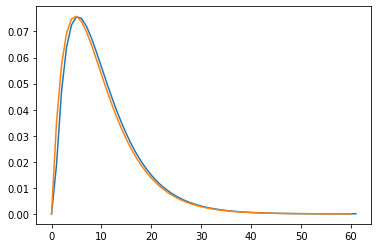

In [418]:

xs= np.linspace(0, 60, 61)
#generation_interval = gamma_dist.pdf(xs, k, scale=theta)
#plt.plot(xs, generation_interval)

# http://www.eajournals.org/wp-content/uploads/On-the-Sum-of-Exponentially-Distributed-Random-Variables-A-Convolution-Approach1.pdf
def new_pdf(z, L1, L2):
    term_0 = L1*L2/(L2-L1)
    term_1 = (np.exp(-L1*z) - np.exp(-L2*z))
    return term_0 * term_1


gen_int_dist = [0]
for day in range(60):
    gen_int_dist.append(quad(new_pdf, day, day+1, args=(gamma, mu))[0])
gen_int_dist.append(quad(new_pdf, day+1, np.inf, args=(gamma, mu))[0])
generation_interval = np.asarray(gen_int_dist)
plt.plot(gen_int_dist)

plt.plot(xs, new_pdf(xs, gamma, mu))




In [419]:
df = pd.DataFrame()
df['t'] = list(range(len(gen_int_dist)))
df['prob'] = generation_interval#gen_int_dist
df.to_csv('gen_int_distribution.csv', index=False)

In [420]:
#plt.plot(xs, expon.pdf(xs, scale=1/gamma))
scale = 1/gamma

def int_expon(xs, shape):
    expon_dist = expon.pdf(xs, scale=shape)
    return expon_dist

delay_dist = [0]
for day in range(20):
    delay_dist.append(quad(int_expon, day, day+1, args=(scale))[0])
delay_dist.append(quad(int_expon, day+1, np.inf, args=(scale))[0])

df = pd.DataFrame()
df['t'] = list(range(20+2))
df['prob'] = delay_dist
df.to_csv('delay_distribution.csv', index=False)

In [433]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7277829/

# beta: infection rate - number of people that an infective person infects each day
# inverse of average latent time
# mu: recovery + death rate


#https://www.icts.res.in/sites/default/files/PuneR0talk.pdf
def seir(conditions, t,  gamma, mu):
    beta = b(t)
    S, E, I, R = conditions

    N = S+ E+ I + R
    dSdt = -beta * S/N * I
    dEdt = beta * I *  S/ N - gamma*E
    dIdt = gamma*E - mu * I
    dRdt = mu*I
    
    return (dSdt, dEdt, dIdt, dRdt)


In [434]:
init_conditions = [1000000, 1, 0, 0 ]
integrated = odeint(seir, init_conditions, t, args=(gamma, mu))
Nt = np.sum(init_conditions)

&lt;matplotlib.legend.Legend at 0x1cbda14ebe0&gt;

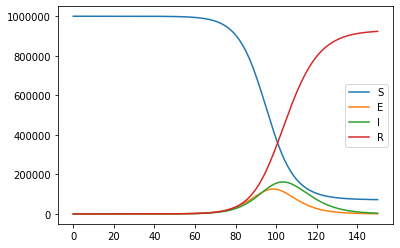

In [435]:
plt.plot(t, integrated[:, 0], label='S')
plt.plot(t, integrated[:, 1], label = 'E')
plt.plot(t, integrated[:, 2], label='I')
plt.plot(t, integrated[:, 3], label='R')
plt.legend()

&lt;matplotlib.legend.Legend at 0x1cbda1bfef0&gt;

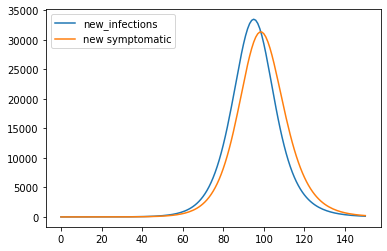

In [436]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3935673/
# R0 beta/gamma in SEIR model
# Re (Rt) = R0 * S/N

# https://www.icts.res.in/sites/default/files/PuneR0talk.pdf
#R0 = beta*S0/*mu)

# https://www.medrxiv.org/content/10.1101/2020.06.18.20134858v3.full.pdf
# Rt_inst = beta * S * D
# Rt_case = 
df = pd.DataFrame()
df['t'] = t
df['S'] = integrated[:, 0]
df['E'] = integrated[:, 1]
df['I'] = integrated[:, 2]
df['R'] = integrated[:, 3]
df['beta(t)'] = b_vec
df['R(t)'] = b_vec * df['S'] * 1/mu /Nt
df['new_infections'] = b_vec * df['I'] *  df['S']/ Nt 
df['new_symptomatic'] = gamma*df['E']
df.to_csv('seir_results.csv', index=False)
plt.plot(t, df['new_infections'], label= 'new_infections')
plt.plot(t, df['new_symptomatic'], label = 'new symptomatic')
plt.legend()

&lt;matplotlib.legend.Legend at 0x1cbda23f240&gt;

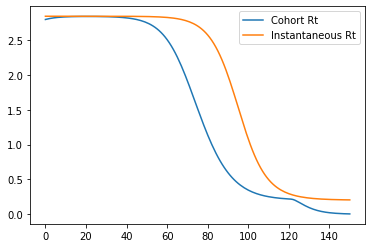

In [437]:
Rt = df['R(t)']
t = range(len(Rt))
Rt_case = np.convolve(Rt, generation_interval, mode='same')#[len(generation_interval):-(len(generation_interval)-1)]
plt.plot(Rt_case, label='Cohort Rt')#t[len(generation_interval):],Rt_case)
plt.plot(Rt, label='Instantaneous Rt') 
plt.legend()

&lt;matplotlib.legend.Legend at 0x1cbda2ab9b0&gt;

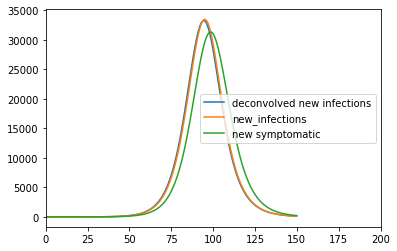

In [438]:
deconvolution_results = pd.read_csv('deconvolved.csv')
deconvolution_results = deconvolution_results[deconvolution_results['time']>=0] 
plt.plot(deconvolution_results['time'], deconvolution_results['RL_result'], label='deconvolved new infections')
plt.plot(t, df['new_infections'], label= 'new_infections')
plt.plot(t, df['new_symptomatic'], label = 'new symptomatic')
plt.xlim(0, 200)

plt.legend()

&lt;matplotlib.legend.Legend at 0x1cbdb583d30&gt;

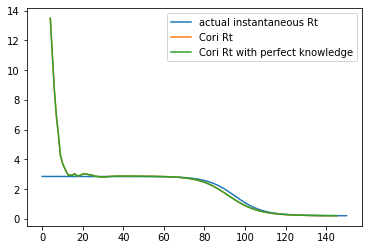

In [444]:
cori_estimates = pd.read_csv('cori.csv')
wt_estimates = pd.read_csv('wt.csv')

cori_true = pd.read_csv('cori_true.csv')
wt_true = pd.read_csv('wt_true.csv')

plt.plot(t, df['R(t)'], label = 'actual instantaneous Rt')
#plt.plot(t, Rt_case, label = 'actual cohort Rt')

plt.plot((cori_estimates['t_start']), cori_estimates['Mean(R)'], label='Cori Rt')
#plt.plot(wt_estimates['t_start'], wt_estimates['Mean(R)'], label='Wallinga Rt')

plt.plot(cori_true['t_start'], cori_estimates['Mean(R)'], label='Cori Rt with perfect knowledge')
#plt.plot(wt_true['t_start'], wt_estimates['Mean(R)'], label='Wallinga Rt with perfect knowledge')

#plt.ylim(0, 2)

plt.legend()